# A Basic Example of Topic Modeling

This is an example of how to perform topic modeling.

There are several settings that can be tuned for choosing which articles to be loaded from BigQuery, as well as hyperparameters for the algorithms. There are two different topic modeling algorithms implemented in this example, non-negative matrix factorization (NMF) and Latent Dirichlet Allocation (LDA).

In [1]:
# Necessary for importing modules from a sub-directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
if os.getcwd().split('/')[-1] == 'notebook_examples':
    os.chdir(r"../")


# Importing libraries
import pandas_gbq
import pickle
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models, corpora
from src.efselabwrapper.pipeline import run_processing_pipeline

## Data Settings
This is where the parameters are set for choosing which articles to perform topic modeling with.

In this example, articles from Dagens Nyheter and Dagens Industri are chosen. From each brand, 500 articles are randomly sampled from the year 2020.

The number of articles needs to big enough to make the statistical relationships between the words reliable, hence giving meaningful topics. For advanced analysis we recommend this to be bigger than 5000, preferably around 10 000. To preprocess 10 000 articles takes about 1.5-2 minutes (which is the most time-consuming part of the modeling).

## Model Settings
This is where parameters for the modeling are chosen.
Part of Speech Tags (pos_tags) represents which Part of Speach classes are used in the modeling. In this example, all classes except nouns are filtered out.

The number of topics can be chosen as well as which algorithm to use. Which algorithm to use is highly use case dependent, hence there is no general best algorithm. A throughout comparison between the two algorithms can be found in our thesis (link in README), but as a short summary one can say that NMF is faster and creates more specific topics while LDA is slower and create more general and comprehensive topics.

In [4]:
# tags to choose:
# ['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV', 'SCONJ', 'AUX', 'PUNCT', 'ADP', 'PRON','DET', 'PART', 'CCONJ', 'NUM', 'INTJ']
pos_tags = ["NOUN"]

# Choose algorithm, LDA or NMF
algorithm = 'NMF' #'NMF' | 'LDA'

# Number of topics
NUM_TOPICS = 40

# NMF settings
NMF_NORM = 'frobenius' # ‘frobenius’ | ‘kullback-leibler’ | ‘itakura-saito’
NMF_SOLVER = 'mu' # ‘cd’ | ‘mu’
INIT = None # None | ‘random’ | ‘nndsvd’ | ‘nndsvda’ | ‘nndsvdar’ | ‘custom’
ALPHA = 0 # float

In [5]:
# Preprocess
efselab_parsed_corpus = run_processing_pipeline(df, pos_tags)

## Build Topic Model

In [6]:
if algorithm == 'LDA':
    # Set mallet path
    mallet_path ='src/mallet-2.0.8/bin/mallet'
    
    # Format Gensim components for data
    id2word = corpora.Dictionary(efselab_parsed_corpus)
    id2word.filter_extremes(no_below=2)
    corpus = [id2word.doc2bow(text) for text in efselab_parsed_corpus]

    # Train model
    model = models.wrappers.LdaMallet(mallet_path,
                                      corpus=corpus,
                                      id2word=id2word,
                                      num_topics=NUM_TOPICS)
    topics = model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=False)
    
    doc_topic_weights = np.array([[e[1] for e in doc] for doc in model[corpus]])

    
if algorithm == 'NMF':
    # Create TF-IDF
    vectorizer = TfidfVectorizer(
        lowercase=False,
        tokenizer=lambda x: x,
        max_df=0.95,
        min_df=2,
        max_features=None,
        use_idf=True
    )
    tf_idf = vectorizer.fit_transform(efselab_parsed_corpus)
    feature_names = vectorizer.get_feature_names()
    
    # Train model
    model = NMF(random_state=0, tol=0.0001, verbose=0, shuffle=False,\
            n_components=NUM_TOPICS, beta_loss=NMF_NORM, solver=NMF_SOLVER, \
            init=INIT, alpha=ALPHA, max_iter=500)

    W = model.fit_transform(tf_idf, y=feature_names)
    H = model.components_   

    def get_NMF_topics(model, feature_names, n_top_words):
        all_topics = []
        for topic_idx, topic in enumerate(model.components_):
            sumtopic = np.sum(topic)
            topic_formatted = (topic_idx, [(feature_names[i], topic[i]/sumtopic) for i in topic.argsort()[:-n_top_words - 1:-1]])
            all_topics.append(topic_formatted)
        return all_topics

    topics = get_NMF_topics(model, feature_names, 10)
    doc_topic_weights = W

doc_topic = [np.argmax(e) for e in doc_topic_weights]
topic_counts = [doc_topic.count(i) for i in range(len(topics))]


## Print Topics

T1: miljon krona kvartal bolag omsättning rörelseresultat vd resultat aktie utdelning 
T2: regering förslag land kris stöd åtgärd möte fråga situation riksdag 
T3: aktie stockholmsbörs krona uppgång börs kurs handel tisdag måndag innehav 
T4: match mål seger poäng lag säsong period halvlek omgång målvakt 
T5: polis lägenhet presstalesperson plats mord undersökning förundersökning sjukhus ambulans mordförsök 
T6: riktkurs krona behåll köp rekommendation köprekommendation collier analys tisdag bank 
T7: dollar miljard kvartal aktie förväntning resultat intäkt analytiker rapport efterfrågan 
T8: parti val fråga väljare moderat socialdemokrat språkrör miljöparti procentenhet politik 
T9: coronavirus antal land virus smitta dygn smittspridning pandemi dödsfall värld 
T10: barn vän familj minne tal barnbarn ålder liv förälder son 
T11: miljard krona affär överskott bolag emission riksgäld stat värde oljefond 
T12: skola elev barn kötid lärare förälder distansundervisning munskydd kommun stud

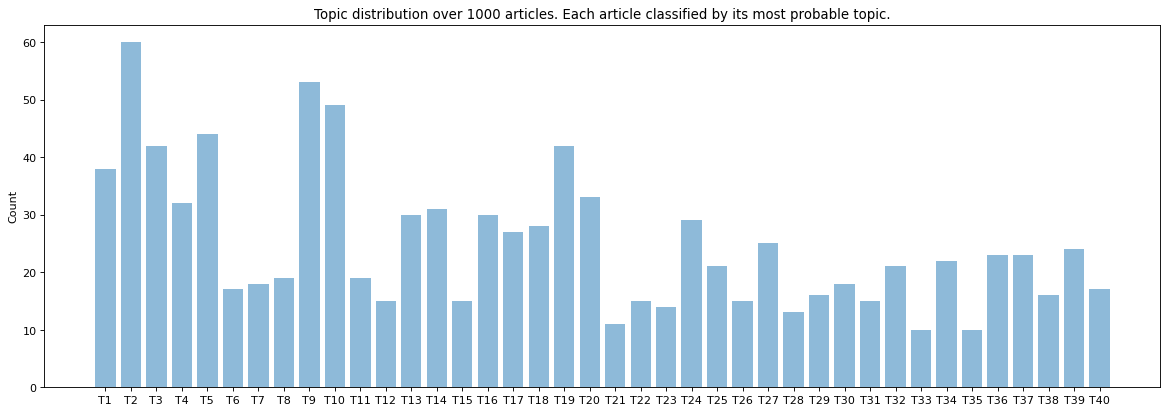

In [7]:
for topic in topics:
    print(f'T{topic[0]+1}:', ' '.join([f'{e[0]}' for e in topic[1]]), '')
    
# Plot bar chart
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
topic_axis = [f'T{i+1}' for i in range(len(topics))]
y_pos = np.arange(len(topic_axis))
plt.bar(y_pos, topic_counts, align='center', alpha=0.5)
plt.xticks(y_pos, topic_axis)
plt.ylabel('Count')
plt.title(f'Topic distribution over {sum(topic_counts)} articles. Each article classified by its most probable topic.')
plt.show()

In [8]:
import pyLDAvis
pyLDAvis.enable_notebook()

if algorithm == 'LDA':
    import pyLDAvis.gensim
    conv_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
    
if algorithm == 'NMF':
    W_norm = W / W.sum(axis=1)[:, None]
    H_smooth = np.add(H, 0.000000000001)
    H_norm = H_smooth / H_smooth.sum(axis=1)[:, None]
    term_freq = tf_idf.sum(axis=0).getA1()
    doc_len = tf_idf.sum(axis=1).getA1()

    opts = {'vocab': feature_names, 
            'doc_lengths': doc_len.tolist(),
            'term_frequency': term_freq.tolist(),
            'doc_topic_dists': W_norm.tolist(),
            'topic_term_dists': H_norm.tolist(),
            'sort_topics': False
           }
    
pyLDAvis.gensim.prepare(conv_model, corpus, id2word, sort_topics=False) if algorithm == 'LDA' else pyLDAvis.prepare(**opts)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.205165 -0.010395       1        1  4.424773
1      0.110902 -0.056617       2        1  6.460227
2     -0.194923  0.157136       3        1  2.871905
3      0.101268  0.156011       4        1  3.198137
4      0.162282 -0.066199       5        1  3.524100
5     -0.095842  0.040780       6        1  1.635375
6     -0.178341  0.172386       7        1  2.211661
7      0.197978  0.049013       8        1  3.187874
8      0.034306 -0.047548       9        1  4.240674
9      0.193981 -0.003931      10        1  4.851517
10    -0.164103 -0.124026      11        1  2.245222
11     0.085960 -0.117103      12        1  1.610253
12    -0.124658  0.100704      13        1  2.965021
13    -0.004288 -0.092968      14        1  3.057879
14    -0.168650  0.037239      15        1  1.427908
15    -0.167857 -0.032622      16        1  2.740939
16     0.089748  0.105637      17        1  2.101889
17     0.159452  0.048100      18        1  1.952725
18     0.104772  0.011961      19        1  3.607904
19     0.056840 -0.162733      20        1  3.354553
20    -0.022960 -0.138286      21        1  1.393938
21     0.086176  0.109002      22        1  2.023973
22    -0.106577 -0.221913      23        1  1.197412
23     0.067585 -0.006031      24        1  2.931505
24    -0.153638  0.186826      25        1  1.989172
25     0.125052 -0.084852      26        1  1.860284
26     0.168024  0.034926      27        1  2.854187
27    -0.193697 -0.024062      28        1  1.165357
28     0.168376  0.089645      29        1  1.886388
29    -0.055766  0.003476      30        1  2.312429
30    -0.053519 -0.137459      31        1  1.557173
31    -0.081782 -0.045119      32        1  2.145081
32    -0.085532 -0.038935      33        1  1.612772
33    -0.026248 -0.065369      34        1  2.096098
34    -0.034602  0.057551      35        1  1.106292
35     0.107891  0.138455      36        1  2.254214
36    -0.048140  0.015693      37        1  2.141038
37    -0.047041 -0.067382      38        1  1.319188
38     0.155866 -0.032514      39        1  2.398754
39     0.036869  0.061525      40        1  2.084209, topic_info=            Term       Freq      Total Category  logprob  loglift
2360       krona  36.000000  36.000000  Default  30.0000  30.0000
33         aktie  26.000000  26.000000  Default  29.0000  29.0000
460        bolag  26.000000  26.000000  Default  28.0000  28.0000
2850     miljard  22.000000  22.000000  Default  27.0000  27.0000
3386       polis  17.000000  17.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
4653      tisdag   1.084620   8.524806  Topic40  -4.6224   1.8090
4470    säkerhet   0.574731   2.116168  Topic40  -5.2575   2.5673
666   coronakris   0.625426   5.028355  Topic40  -5.1730   1.7864
4236   spridning   0.596885   4.366574  Topic40  -5.2197   1.8808
130        antal   0.610520  13.455652  Topic40  -5.1971   0.7779

[2185 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
9        26  0.888845          advokat
13        1  0.108526            affär
13       11  0.325577            affär
13       23  0.325577            affär
13       32  0.108526            affär
...     ...       ...              ...
5323     19  1.647429  överbefälhavare
5326     37  0.397831  överenskommelse
5339      4  1.050225         överläge
5343     11  0.898066        överskott
5343     15  0.299355        överskott

[1596 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])